In [4]:
# Dependencies
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import requests
import json
import alpha_vantage
from config import apiKey
from alpha_vantage.timeseries import TimeSeries
import keras
import random
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

def one_year_data(stock_ticker): 
    yesterday = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
    past_year = datetime.strftime(datetime.now() - timedelta(366), '%Y-%m-%d')
    

    url = "https://www.alphavantage.co/query?"
    query_url = f"{url}function=TIME_SERIES_DAILY&symbol={stock_ticker}&outputsize=full&apikey={apiKey}" 

    response = requests.get(query_url).json() 

    df = pd.DataFrame(response["Time Series (Daily)"]) 

    df_transposed = df.T # or df1.transpose()

    df_filtered = df_transposed[yesterday : past_year] 

    df_filtered.rename(columns={'4. close':'close', '3. low':'low', '2. high':'high', '5. volume':'volume'}, inplace=True)
    
    df_filtered.drop('1. open', axis=1, inplace=True)
    
    df_filtered = df_filtered[["close", "low", "high", "volume"]]
    
    ten_day_model = load_model("ML/model_ten_day.h5")
    thirty_day_model = load_model("ML/model_thirty_day.h5")
    sixty_day_model = load_model("ML/model_sixty_day.h5")    
    
    #sixty day model
    dataset = df_filtered.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    X_test, y_test = [], []
    for i in range(61,len(dataset)):
        X_test.append(scaled_data[i-61:i-1,0:4])
        y_test.append(scaled_data[i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    closing_price = sixty_day_model.predict(X_test)
    
    final = []
    for price in closing_price:
        final.append(np.pad(price, (0, 3), 'constant'))
    final_price = scaler.inverse_transform(final)
    close = []
    for price in final_price:
        close.append(price[0])
    
    valid_sixty_day = df_filtered[61:] 
    valid_sixty_day["predictions"] = close
    
    #thirty day model 
    dataset = df_filtered.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    X_test, y_test = [], []
    for i in range(31,len(dataset)):
        X_test.append(scaled_data[i-31:i-1,0:4])
        y_test.append(scaled_data[i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    closing_price = thirty_day_model.predict(X_test)
    
    final = []
    for price in closing_price:
        final.append(np.pad(price, (0, 3), 'constant'))
    final_price = scaler.inverse_transform(final)
    close = []
    for price in final_price:
        close.append(price[0])
    
    valid_thirty_day = df_filtered[31:] 
    valid_thirty_day["predictions"] = close
    
    #ten day model
    dataset = df_filtered.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    X_test, y_test = [], []
    for i in range(11,len(dataset)):
        X_test.append(scaled_data[i-11:i-1,0:4])
        y_test.append(scaled_data[i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    closing_price = ten_day_model.predict(X_test)
    
    final = []
    for price in closing_price:
        final.append(np.pad(price, (0, 3), 'constant'))
    final_price = scaler.inverse_transform(final)
    close = []
    for price in final_price:
        close.append(price[0])
    
    valid_ten_day = df_filtered[11:]  
    valid_ten_day["predictions"] = close
    
    
    
    return valid_sixty_day, valid_thirty_day, valid_ten_day
     
    

sixty, thirty, ten = one_year_data("GOOG")    

/Users/addisonpietroburgo/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/addisonpietroburgo/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/addisonpietroburgo/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/addisonpietroburgo/anaconda3/envs/

TypeError: unhashable type: 'numpy.ndarray'

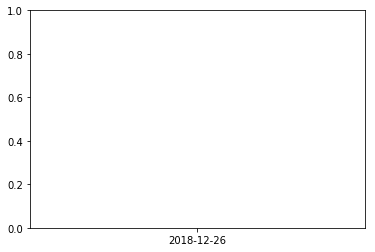

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(sixty[['close', 'predictions']])
plt.plot(thirty[['predictions']])
plt.plot(ten[['predictions']])